# Non-flat cosmologies

Play around with non-flat models, and analytical predictions for $f_\star$ and $g_\star$.

### Likelihood parameters: linear power $\Theta$

We will use a maximum of five parameters to describe the linear power spectrum across the redshift range of interest.

$$ \Theta = \{ \Delta_p^2, n_p, \alpha_p, f_\star, g_\star \} = \{ \Theta_p, f_\star, g_\star \} $$

Three of them will describe the linear power at $z_\star$, in velocity units (km/s). We will use a Taylor expansion of the logarithm of the linear power around $k_p = 0.009$ s/km. 

$$ \Delta_p^2 = \frac{k_p^3}{2 \pi^2} P_L(z_\star,k_p) $$

$$ n_p = \frac{\partial \log P_L(z_\star, k)}{\partial \log(k) } \Bigr\rvert_{k_p} $$

$$ \alpha_p = \frac{\partial^2 \log P_L(z_\star, k)}{\partial \log^2(k) } \Bigr\rvert_{k_p} $$

The other two will describe the redshift evolution of the linear growht $D(z)$ and the Hubble expansion $H(z)$, with respect $z_\star=3$, normalized by the expected evolution in an Einstein-de Sitter universe. 

$$ f_\star = f(z_\star) = \frac{\partial \log D(z)}{\partial \log a(z)} \Bigr\rvert_{z_\star} $$

$$ g_\star = g(z_\star) = \frac{\partial \log H(z)}{\partial \log (1+z)^{3/2}} \Bigr\rvert_{z_\star} $$


In [1]:
%matplotlib inline
import numpy as np
import os
import copy
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb
from camb import model, initialpower
import fit_pk
import read_genic

In [2]:
# setup cosmology
cosmo = fit_pk.get_cosmology(mnu=0.0,H0=75.0)
fit_pk.print_info(cosmo)
# fit power around this
z_star=3.0
kp_Mpc=0.7
# get linear power parameters, in comoving units
linP_params_Mpc=fit_pk.parameterize_cosmology_Mpc(cosmo,z_star=z_star,kp_Mpc=kp_Mpc)

H0 = 75.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96


In [3]:
def Omegas_mkL(cosmo):
    O_b=cosmo.omegab
    O_c=cosmo.omegac
    O_nu=cosmo.omeganu
    O_m=O_b+O_c+O_nu
    O_k=cosmo.omk
    O_L=1.0-O_m-O_k
    return O_m, O_k, O_L

In [4]:
def E_z(cosmo,z):
    """Returns E(z), where H^2(z) = H^2_0 E(z)"""
    O_m,O_k,O_L=Omegas_mkL(cosmo)
    return O_m*(1+z)**3+O_L+O_k*(1+z)**2

In [5]:
def dEdz(cosmo,z):
    """Returns dE(z)/dz, where H^2(z) = H^2_0 E(z)"""
    O_m,O_k,O_L=Omegas_mkL(cosmo)    
    return 3*O_m*(1+z)**2+O_k*(1+z)

In [6]:
def g_z(cosmo,z):
    return (1+z)/3/E_z(cosmo,z)*dEdz(cosmo,z)

In [7]:
g_star=linP_params_Mpc['g_star']
g_star_approx=g_z(cosmo,z_star)
print(g_star,'approximated as',g_star_approx)

0.9562014848059245 approximated as 0.9557764105800073


Similary, we can also compute $f(z)$ as:
$$ f(z) = \frac{\partial \log D(z)}{\partial \log a(z)} = - \frac{1+z}{D(z)} \frac{\partial D}{\partial z}$$
We will then use the approximation form Eisenstein & Hu (1997):
$$ D(z) = \frac{5 \, \Omega_m(z)}{2 (1+z)} F^{-1}(z)  \qquad \qquad 
F(z) = \Omega^{4/7}_m(z) - \Omega_\Lambda(z) 
    + \left(1 + \frac{\Omega_m(z)}{2} \right) \left(1 + \frac{\Omega_\Lambda(z)}{70} \right) $$
with 
$$ \Omega_m(z) = \Omega_m \frac{(1+z)^3}{E(z)}  \qquad  \qquad 
    \Omega_\Lambda(z) = \Omega_\Lambda \frac{1}{E(z)}  $$

We can also compute derivatives of these $\Omega$ variables:
$$ \frac{1}{\Omega_m(z)} \frac{\partial \Omega_m(z)}{\partial z} 
    = \frac{3}{1+z} - \frac{1}{E(z)} \frac{\partial E (z)}{\partial z} $$
and
$$ \frac{1}{\Omega_\Lambda(z)} \frac{\partial \Omega_\Lambda(z)}{\partial z} 
    = - \frac{1}{E(z)} \frac{\partial E (z)}{\partial z} $$
and 
$$ \frac{\partial F(z)}{\partial z} = \frac{4}{7} \Omega^{-3/7}_m(z) \frac{\partial \Omega_m(z)}{\partial z} 
    - \frac{\partial \Omega_\Lambda(z)}{\partial z}  
    + \left(1 + \frac{\Omega_m(z)}{2} \right) \frac{1}{70} \frac{\partial \Omega_\Lambda(z)}{\partial z}  
    + \frac{1}{2} \frac{\partial \Omega_m(z)}{\partial z} \left(1 + \frac{\Omega_\Lambda(z)}{70} \right) $$

In [8]:
def Om_z(cosmo,z):
    """Returns Omega_m(z), for CDM+baryons+nu"""
    O_m,O_k,O_L=Omegas_mkL(cosmo)
    # get E(z) = H^2(z) / H^2_0
    return O_m * (1+z)**3 / E_z(cosmo,z)

In [9]:
def OL_z(cosmo,z):
    """Returns Omega_L(z)"""
    O_m,O_k,O_L=Omegas_mkL(cosmo)
    # get E(z) = H^2(z) / H^2_0
    return O_L / E_z(cosmo,z)

In [10]:
print('E(z=3)',E_z(cosmo,z_star))
print('Omega_m(z=3)',Om_z(cosmo,z_star))
print('Omega_L(z=3)',OL_z(cosmo,z_star))

E(z=3) 16.903999999999996
Omega_m(z=3) 0.9557764105800075
Omega_L(z=3) 0.044223589419992645


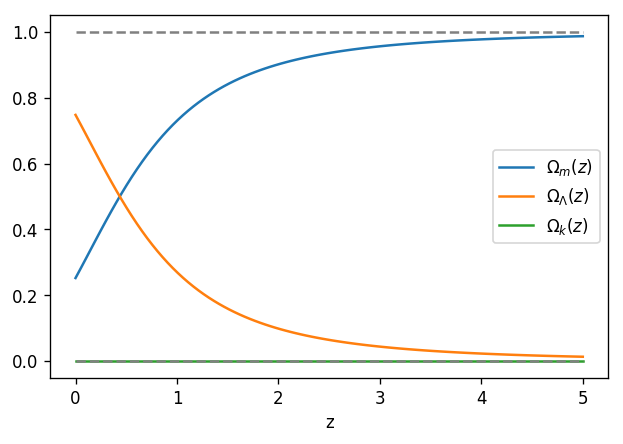

In [11]:
z=np.linspace(0.0,5.0,100)
plt.figure()
plt.plot(z,Om_z(cosmo,z),label=r'$\Omega_m(z)$')
plt.plot(z,OL_z(cosmo,z),label=r'$\Omega_\Lambda(z)$')
plt.plot(z,1-Om_z(cosmo,z)-OL_z(cosmo,z),label=r'$\Omega_k(z)$')
plt.plot(z,np.ones_like(z),'--',color='gray')
plt.plot(z,np.zeros_like(z),'--',color='gray')
plt.xlabel('z')
plt.legend()

In [12]:
def F_z(cosmo,z):
    """Returns function used in growth factor from EH97"""
    Om=Om_z(cosmo,z)    
    OL=OL_z(cosmo,z)
    return Om**(4/7)-OL+(1+Om/2)*(1+OL/70)

In [13]:
def D_z(cosmo,z):
    """Returns growth factor from EH97"""
    return 5*Om_z(cosmo,z)/2/(1+z)/F_z(cosmo,z)

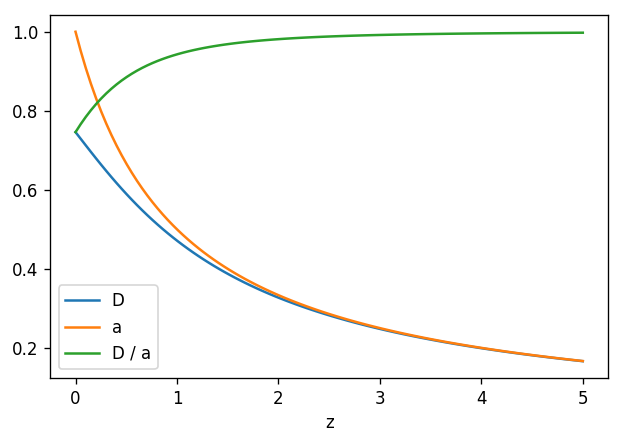

In [14]:
z=np.linspace(0.0,5.0,100)
plt.figure()
plt.plot(z,D_z(cosmo,z),label='D')
plt.plot(z,1.0/(1+z),label='a')
plt.plot(z,D_z(cosmo,z)*(1+z),label='D / a')
plt.xlabel('z')
plt.legend()

In [15]:
def dOmdz(cosmo,z):
    """Returns derivative of Omega_m(z), for CDM+baryons+nu"""
    return Om_z(cosmo,z)* (3/(1+z) - dEdz(cosmo,z)/E_z(cosmo,z))

In [16]:
def dOLdz(cosmo,z):
    """Returns derivative of Omega_L(z)"""
    return -OL_z(cosmo,z) * dEdz(cosmo,z)/E_z(cosmo,z)

In [17]:
def dFdz(cosmo,z):
    """Derivative of F(z), function used in growth factor from EH97"""
    Om=Om_z(cosmo,z)    
    OL=OL_z(cosmo,z)
    return (4/7*Om**(-3/7) + 1/2 + OL/140)*dOmdz(cosmo,z) + (-1+1/70+Om/140)*dOLdz(cosmo,z)

In [18]:
def dDdz(cosmo,z):
    """Derivative of growth factor from EH97"""
    D = D_z(cosmo,z)
    return D*(dOmdz(cosmo,z)/Om_z(cosmo,z) - 1/(1+z) - dFdz(cosmo,z)/F_z(cosmo,z) )

In [19]:
def f_z(cosmo,z):
    return -(1+z)*dDdz(cosmo,z)/D_z(cosmo,z)

In [20]:
f_star=linP_params_Mpc['f_star']
f_star_approx=f_z(cosmo,z_star)
print(f_star,'approximated as',f_star_approx)
# crude approximation
print(f_star,'rouhgly',(Om_z(cosmo,z_star))**0.55)

0.97495182314 approximated as 0.9758542519935619
0.97495182314 rouhgly 0.9754296870618359


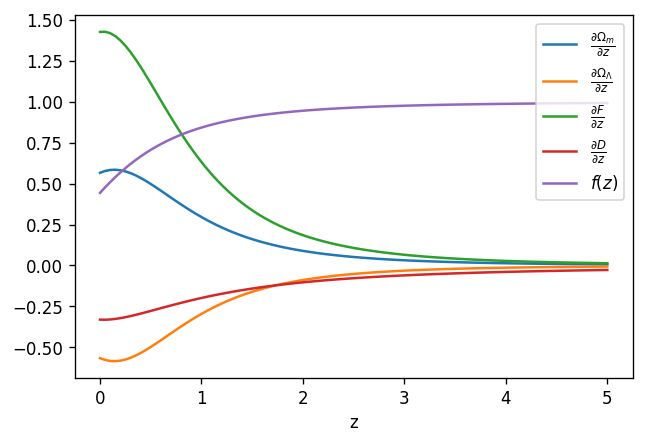

In [21]:
z=np.linspace(0.0,5.0,100)
plt.figure()
plt.plot(z,dOmdz(cosmo,z),label=r'$\frac{\partial \Omega_m}{\partial z}$')
plt.plot(z,dOLdz(cosmo,z),label=r'$\frac{\partial \Omega_\Lambda}{\partial z}$')
plt.plot(z,dFdz(cosmo,z),label=r'$\frac{\partial F}{\partial z}$')
plt.plot(z,dDdz(cosmo,z),label=r'$\frac{\partial D}{\partial z}$')
plt.plot(z,f_z(cosmo,z),label=r'$f(z)$')
plt.xlabel('z')
plt.legend()

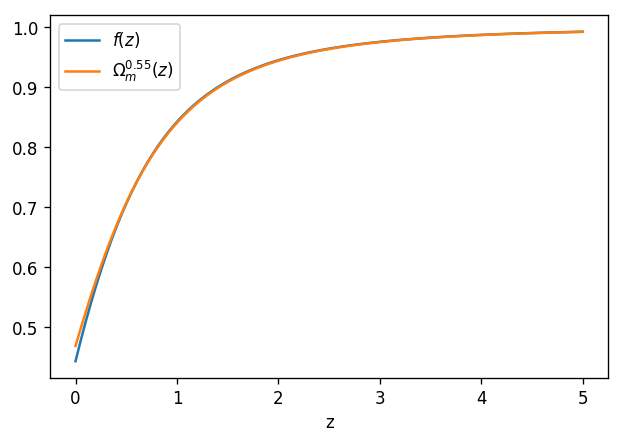

In [22]:
z=np.linspace(0.0,5.0,100)
plt.figure()
plt.plot(z,f_z(cosmo,z),label=r'$f(z)$')
plt.plot(z,(Om_z(cosmo,z))**0.55,label=r'$\Omega^{0.55}_m(z)$')
plt.xlabel('z')
plt.legend()

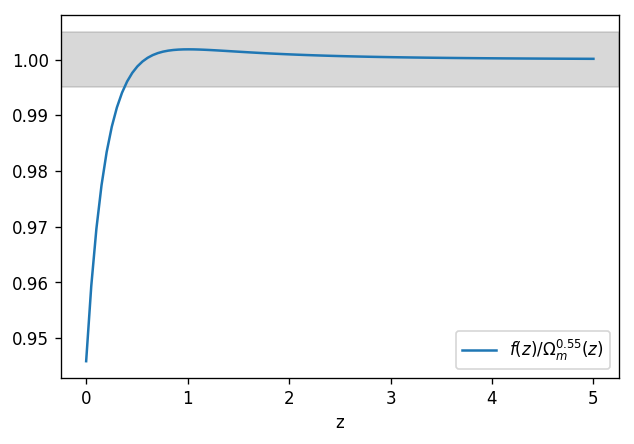

In [23]:
z=np.linspace(0.0,5.0,100)
plt.figure()
plt.plot(z,f_z(cosmo,z)/(Om_z(cosmo,z))**0.55,label=r'$f(z) / \Omega^{0.55}_m(z)$')
plt.xlabel('z')
plt.axhspan(0.995,1.005,alpha=0.3, color='gray')
plt.legend()

It looks like the approximation $f(z) \approx \Omega^{0.55}_m(z)$ works well enough for flat $\Lambda$CDM models.

This means that if we want to run a simulation with a differnet value of $f_\star$, we can choose a different value of $\Omega_m$ while keeping fixed $\Omega_m h^2$, to keep fix the transfer function.

If we also wanted to run simulations with different values of $g_\star$ we would have to add curvature, but I don't think we'll ever need that.

In [24]:
def H0_from_f_star(target_f_star,z_star):
    """Modify fiducial cosmology, to have the right f_star"""
    cosmo_fid=fit_pk.get_cosmology(mnu=0.0)
    # will not modify physical densities
    ombh2=cosmo_fid.ombh2 
    omch2=cosmo_fid.omch2
    ommh2=ombh2+omch2
    # figure out desired Om(z=z_star) from desired f(z_star)
    omm_star=target_f_star**(1/0.55)
    # from Om(z_star), compute Om(z=0) in flat LCDM
    omm=1/(1+(1+z_star)**3*(1/omm_star-1))
    # given Omega_m, figure out Hubble parameter
    h=np.sqrt(ommh2/omm)
    cosmo=fit_pk.get_cosmology(mnu=0.0,H0=100.0*h)
    return cosmo

In [25]:
def mimic_cosmo(target_linP_Mpc,kp_Mpc,target_f_star,z_star):
    """Modify fiducial cosmology, to have the right linear power at z_star (in comoving units) and f_star"""
    cosmo_fid=fit_pk.get_cosmology(mnu=0.0)
    # will not modify physical densities
    ombh2=cosmo_fid.ombh2 
    omch2=cosmo_fid.omch2
    ommh2=ombh2+omch2
    # figure out desired Om(z=z_star) from desired f(z_star)
    omm_star=target_f_star**(1/0.55)
    # from Om(z_star), compute Om(z=0) in flat LCDM
    omm=1/(1+(1+z_star)**3*(1/omm_star-1))
    # given Omega_m, figure out Hubble parameter
    h=np.sqrt(ommh2/omm)
    cosmo=fit_pk.get_cosmology(mnu=0.0,H0=100.0*h)
    # get linear power for this cosmology, at z_star
    k_Mpc, _, linP_Mpc=fit_pk.get_linP_Mpc(pars,snap_zs)
    # 
    fit_pk.get_linP_Mpc(pars,snap_zs)
    return cosmo

In [26]:
# specify target cosmology, and parameterize it
cosmo_target=fit_pk.get_cosmology(mnu=0.0,H0=75.0)
fit_pk.print_info(cosmo_target)
theta_target=fit_pk.parameterize_cosmology_Mpc(cosmo_target,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_target)

H0 = 75.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.97495182314028261, 'g_star': 0.9562014848059245, 'linP_Mpc': poly1d([-0.10752873, -2.30755578,  3.02420959])}


In [27]:
# use parameters to get a cosmology with similar parameters
#mimic_cosmo(theta_target['linP_Mpc'],kp_Mpc,theta_target['f_star'],z_star)
cosmo_mimic=H0_from_f_star(theta_target['f_star'],z_star)
fit_pk.print_info(cosmo_mimic)
theta_mimic=fit_pk.parameterize_cosmology_Mpc(cosmo_mimic,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_mimic)

H0 = 75.56291066444942 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.97447962015461742, 'g_star': 0.9553508628875105, 'linP_Mpc': poly1d([-0.10751988, -2.3075532 ,  3.02388087])}


In [28]:
# specify target cosmology, and parameterize it
cosmo_target=fit_pk.get_cosmology(mnu=0.0,H0=65.0)
fit_pk.print_info(cosmo_target)
theta_target=fit_pk.parameterize_cosmology_Mpc(cosmo_target,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_target)
# use parameters to get a cosmology with similar parameters
#mimic_cosmo(theta_target['linP_Mpc'],kp_Mpc,theta_target['f_star'],z_star)
cosmo_mimic=H0_from_f_star(theta_target['f_star'],z_star)
fit_pk.print_info(cosmo_mimic)
theta_mimic=fit_pk.parameterize_cosmology_Mpc(cosmo_mimic,z_star=z_star,kp_Mpc=kp_Mpc)
print('target parameters',theta_mimic)

H0 = 65.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.9828721852971305, 'g_star': 0.970474934430218, 'linP_Mpc': poly1d([-0.10747232, -2.30760956,  3.02965133])}
H0 = 65.72642171861833 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.0 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
target parameters {'f_star': 0.98232360287645815, 'g_star': 0.969493302088114, 'linP_Mpc': poly1d([-0.10746341, -2.30763938,  3.02928554])}


### Relation between ($f_\star$,$g_\star$) and $\Omega_m$

In [29]:
# get fiducial cosmoloyg, and explore values of f_star and g_star when you vary (Omegam_m,h)
cosmo_fid=fit_pk.get_cosmology(mnu=0.0)
ommh2_fid=(cosmo_fid.omch2+cosmo_fid.ombh2+cosmo_fid.omnuh2)
h=np.linspace(0.60,0.80,100)
omm=ommh2_fid/h**2
om_star=omm*4**3/(omm*4**3+1-omm)

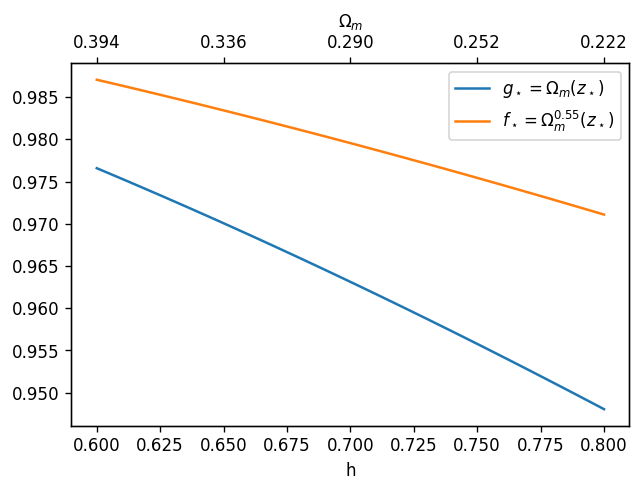

In [30]:
# fancy plot exploring values of f_star and g_star when you vary (Omegam_m,h)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(h,om_star,label=r'$g_\star = \Omega_m(z_\star)$')
ax1.plot(h,om_star**(0.55),label=r'$f_\star = \Omega^{0.55}_m(z_\star)$')
ax1.legend()
ax1.set_xlabel('h')

# add 5 ticks
tick_h = np.linspace(min(h),max(h),5)
def omm_from_h(ommh2_fid,h):
    omm = ommh2_fid/h**2
    return ["%.3f" % z for z in omm]
omm_labels=omm_from_h(ommh2_fid,tick_h)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(tick_h)
ax2.set_xticklabels(omm_labels)
ax2.set_xlabel(r'$\Omega_m$')
plt.show()